# Emotion Dictionary

In [33]:
from src.utils import *
import numpy as np
import pandas as pd 
import re
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import csv, collections
import numpy as np


[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\alienware\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alienware\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alienware\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
%%time
df = pd.read_csv('./data/training.1600000.processed.noemoticon.csv', encoding='latin', header=None, names=['label', 'ids', 'date', 'flag', 'user', 'text'])
df.head()
df.drop(["ids","date","flag","user"], axis=1, inplace=True)
df['label'][df['label'] == 4] = 1
df = preprocess(df)

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: total: 6min 27s
Wall time: 6min 31s


In [14]:
X=df.text
y=df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)

In [15]:
print(X_test)
print(y_test)

291262     ye black red fav color realli want color def l...
1359075    qu buy open hous weekend pm best valu one bedr...
1009651                   fran greet air okay hahahaha thank
1538714    omg that awesom goood luck u meet caaut calgar...
1046690                                 hahahhaha good point
                                 ...                        
203556     beauti shit weather happi see mod practic toda...
163122        fiftythousand follow hugh lauri needl haystack
1176116    follow also hope atleast get also wish get wel...
477177     feel like decent swell sinc last fall hope wav...
897066                                      relaxin busi day
Name: text, Length: 320000, dtype: object
291262     0
1359075    1
1009651    1
1538714    1
1046690    1
          ..
203556     0
163122     0
1176116    1
477177     0
897066     1
Name: label, Length: 320000, dtype: int64


In [16]:
import nltk
import ssl
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
pos=neg=obj=count=0

postagging = []

for review in X_test:
    list = word_tokenize(review)
    postagging.append(nltk.pos_tag(list))



def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None



def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []


    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

   
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0
    
    ###################################################################################
senti_score = []

for pos_val in postagging:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0    
    

              precision    recall  f1-score   support

           0       0.57      0.51      0.54    160000
           1       0.55      0.61      0.58    160000

    accuracy                           0.56    320000
   macro avg       0.56      0.56      0.56    320000
weighted avg       0.56      0.56      0.56    320000

[[81458 78542]
 [62219 97781]]


Text(0.5, 1.0, 'Confusion Matrix')

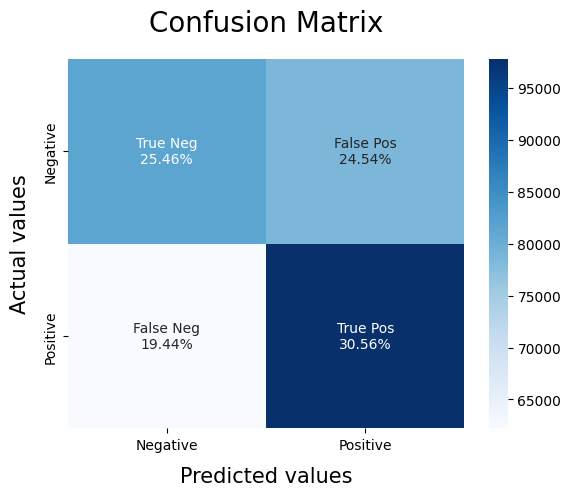

In [18]:
import random
y_predict=[]
for i in range(len(senti_score)):
    if senti_score[i]>0:
        y_predict.append(1)
    elif senti_score[i]==0:
        c=random.choice([0,1])
        y_predict.append(c)
    else:
        y_predict.append(0)
print(classification_report(y_test, y_predict))
cf_matrix=confusion_matrix(y_test, y_predict)
print(cf_matrix)
 
categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':15}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':15}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':20}, pad = 20)


In [243]:
def model_Evaluate(model):
   
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

   
    y_pred = model.predict(X_test)

  
    print(classification_report(y_test, y_pred))
    
   
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [21]:


def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [22]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('./glove/glove.6B.50d.txt')


In [23]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
df2=df.sample(1600000)
text = df2['text'].to_list()

y = df2['label'].to_list()

In [24]:
token = Tokenizer()
token.fit_on_texts(text)

vocab_size  = len(token.word_index) + 1
print('vocabulary_size : ', vocab_size)

encoded_text = token.texts_to_sequences(text)
print(encoded_text[31])

vocabulary_size :  213072
[29, 28, 3447, 10173, 123, 262]


In [25]:
max_length = 120
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')
X.shape

(1600000, 120)

In [26]:
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)


In [27]:
%%time
glove_vectors = dict()

file = open('./glove/glove.twitter.27B.200d.txt', encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1: ])
    glove_vectors[word] = vectors
    
file.close()

print('Glove Vector lenght : ', len(glove_vectors))

word_vector_matrix = np.zeros((vocab_size, 200))

for word, index in token.word_index.items():
    vector = glove_vectors.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector

Glove Vector lenght :  1193514
CPU times: total: 2min 30s
Wall time: 2min 53s


In [28]:
VEC_SIZE = 200
EPOCHS = 5


model = Sequential()
model.add(Embedding(vocab_size, VEC_SIZE, input_length=max_length, weights = [word_vector_matrix], trainable = False))

model.add(Conv1D(128, 8, activation = 'relu'))

model.add(MaxPooling1D(2))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()
history = model.fit(X_train,
                    y_train,
                    epochs = EPOCHS,
                    validation_data = (X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 200)          42614400  
                                                                 
 conv1d (Conv1D)             (None, 113, 128)          204928    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 56, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 56, 128)           0         
                                                                 
 dense (Dense)               (None, 56, 64)            8256      
                                                                 
 dropout_1 (Dropout)         (None, 56, 64)            0         
                                                        

In [30]:
print(y_test)

[0 1 1 ... 1 0 1]


In [35]:
def model_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    newy=[]
    for y in y_pred:
        if y>=0.5:
            newy.append(1)
        else:
            newy.append(0)
    y_pred=newy
  
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':15}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':15}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':20}, pad = 20)

In [ ]:
model_evaluation(model,X_test,y_test)

 5921/10000 [================>.............] - ETA: 58s

In [19]:
X=df.text
y=df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)


              precision    recall  f1-score   support

           0       0.66      0.50      0.57    160000
           1       0.60      0.74      0.66    160000

    accuracy                           0.62    320000
   macro avg       0.63      0.62      0.61    320000
weighted avg       0.63      0.62      0.61    320000

[[ 80406  79594]
 [ 42229 117771]]


Text(0.5, 1.0, 'Confusion Matrix')

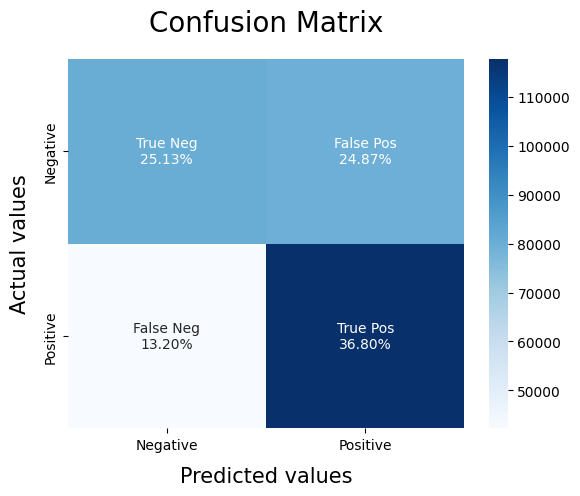

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
y_predict=[]
for sentence in X_test:
    ss = sid.polarity_scores(sentence)
    if ss['compound']>0:
        y_predict.append(1)
    elif ss['compound']==0:
        c=random.choice([0,1])
        y_predict.append(c)
    else:
        y_predict.append(0)

print(classification_report(y_test, y_predict))
cf_matrix=confusion_matrix(y_test, y_predict)
print(cf_matrix)
 
categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':15}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':15}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':20}, pad = 20)